# Income Support in Newfoundland and Labrador 

This [Jupyter Lab](https://jupyter.org) notebook studies a data set on income support benefits in Newfoundland and Labrador, spanning a period from **1991** to **2021.** The intention is to try and reveal patterns and trends in the use of income support over time within the province. The data set used in this study was made available online by **Open Data Newfoundland and Labrador.**

# Overview

## How did income support recipients in the province vary by age?

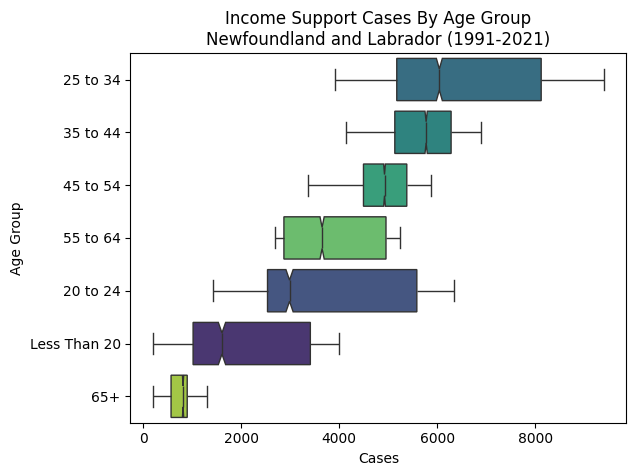

In [348]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import zscore
from sklearn.model_selection import KFold


data = pd.read_csv("./Income_Support.csv", encoding='ISO-8859-1', na_values=['..'])

data = data[data['Geography.Type'] == "Community"]

melted_df = pd.melt(data, id_vars=['Year'], value_vars=[
    'Age..Less.than.20',
    'Age..20...24',
    'Age..25...34',
    'Age..35...44',
    'Age..45...54',
    'Age..55...64',
    'Age..65.'
], var_name='age_category', value_name='age_category_value')

melted_df.dropna(subset=['age_category_value'], inplace=True)

melted_df['age_category'] = melted_df['age_category'].replace({
   'Age..Less.than.20': 'Less Than 20', 
   'Age..20...24': '20 to 24',
   'Age..25...34': '25 to 34',
   'Age..35...44': '35 to 44',
   'Age..45...54': '45 to 54',
   'Age..55...64': '55 to 64',
   'Age..65.': '65+'
})

melted_df['sum_value'] = melted_df.groupby(['Year', 'age_category'])['age_category_value'].transform('sum')

data_group = {
    "Less Than 20": melted_df[melted_df['age_category'] == "Less Than 20"]['sum_value'],
    "20 to 24": melted_df[melted_df['age_category'] == "20 to 24"]['sum_value'],
    "25 to 34": melted_df[melted_df['age_category'] == "25 to 34"]['sum_value'],
    "35 to 44": melted_df[melted_df['age_category'] == "35 to 44"]['sum_value'],
    "45 to 54": melted_df[melted_df['age_category'] == "45 to 54"]['sum_value'],
    "55 to 64": melted_df[melted_df['age_category'] == "55 to 64"]['sum_value'],
    "65+": melted_df[melted_df['age_category'] == "65+"]['sum_value']
}

boxplot_data = [data_group[group] for group in ["Less Than 20", "20 to 24", "25 to 34", "35 to 44", "45 to 54", "55 to 64", "65+"]]

plt.title('Income Support Cases By Age Group\nNewfoundland and Labrador (1991-2021)')
plt.xlabel('Cases')
plt.ylabel('Age Group')

# Sort the box plot in descending order by the median value of each age category.
medians = melted_df.groupby('age_category')['sum_value'].median().sort_values(ascending=True)
ordered_categories = medians.index
sns.boxplot(x="sum_value",y="age_category",data=melted_df,order=medians.index,notch=True,palette="viridis",hue="age_category")
plt.gca().invert_yaxis()


The **25-34** age group had the highest average number of income support cases in the province, followed by groups **35-44** and **45-54.** This is significant; the authors of the data set indicate that ages **25-54** may be considered the "prime" labour force age range, yet we can see that the majority of income support cases fall precisely within this range. The group is **positively** skewed, with a median closer to the lower quartile and a slightly longer right whisker. This may indicate that, while income support is common at lower levels in the 25-34 age range, there are exceptional circumstances, or **outliers** that affect the distribution of cases in that age group. 

The **65+** age range accounted for the least overall cases of income support. In this case, the distribution of cases is **negatively** skewed. There are a number of reasons why this may be the case:

- There may be income support programs for seniors in the province that target a consistent and higher level of support for the majority of the population. However, some individuals may receive low support due to special circumstances, such as additional pensions or alternate sources of income.
- Outliers on the lower end could represent individuals with unique financial situations.
- As seniors typically receive stable government pensions or support, this could result in the clustering at the higher end of income support cases.

## Which communities had the highest average numbers of income support cases?

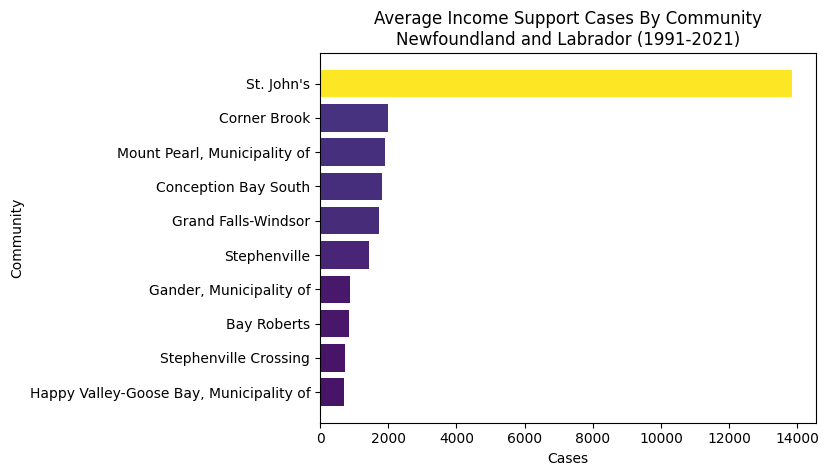

In [349]:
df = data.copy()
df = df.sort_values(by='Year', ascending=False)
df.dropna(subset=['Individuals'],inplace=True)
df['mean_individuals'] = df.groupby('Geography')['Individuals'].transform('mean')
df = df.sort_values(by='mean_individuals', ascending=False)
df.drop_duplicates(subset=['Geography'], inplace=True)
df_top10 = df.head(10)
norm = plt.Normalize(min(df['mean_individuals']), max(df['mean_individuals']))
colors = plt.cm.viridis(norm(df['mean_individuals']))
plt.barh(df_top10['Geography'],df_top10['mean_individuals'],color=colors)
plt.title("Average Income Support Cases By Community\nNewfoundland and Labrador (1991-2021)")
plt.xlabel("Cases")
plt.ylabel("Community")
plt.gca().invert_yaxis()

**St. John's** had the highest average number of individuals on income support by a wide margin. However, one must take population into consideration. **St. John's** is the capital city of the province and its most populated, with over **200,000** people (a significant portion of the entire province's population) residing there.

## Which communities had the highest average percentage of income support cases?

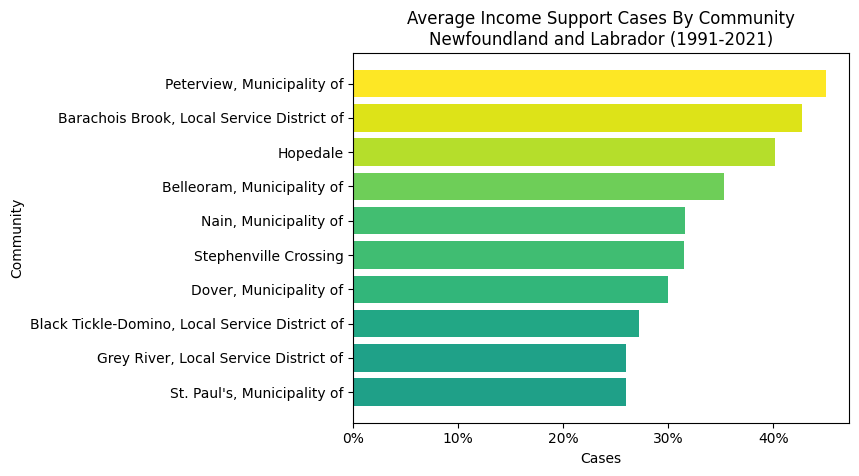

In [350]:
df = data.copy()
df.dropna(subset=['Income.Support.Assistance.Incidence'],inplace=True)
df['mean_incidence'] = df.groupby('Geography')['Income.Support.Assistance.Incidence'].transform('mean')
df = df.sort_values(by='mean_incidence', ascending=False)
df.drop_duplicates(subset=['Geography'],inplace=True)
df_top10 = df.head(10)
norm = plt.Normalize(min(df['mean_incidence']), max(df['mean_incidence']))
colors = plt.cm.viridis(norm(df['mean_incidence']))
plt.barh(df_top10['Geography'],df_top10['mean_incidence'],color=colors)
plt.title("Average Income Support Cases By Community\nNewfoundland and Labrador (1991-2021)")
plt.xlabel("Cases")
plt.ylabel("Community")
plt.gca().invert_yaxis()
# Format the y-axis to show percentages.
def to_percent(y, _):
    return f"{y * 100:.0f}%"  # Convert decimal to percentage.

plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent))

The **Municipality of Peterview** had the highest average incidence of income support in the province, with an average of over **40%** of the population of the community availing of income support benefits.

# Education

## What were the levels of education among income support cases?

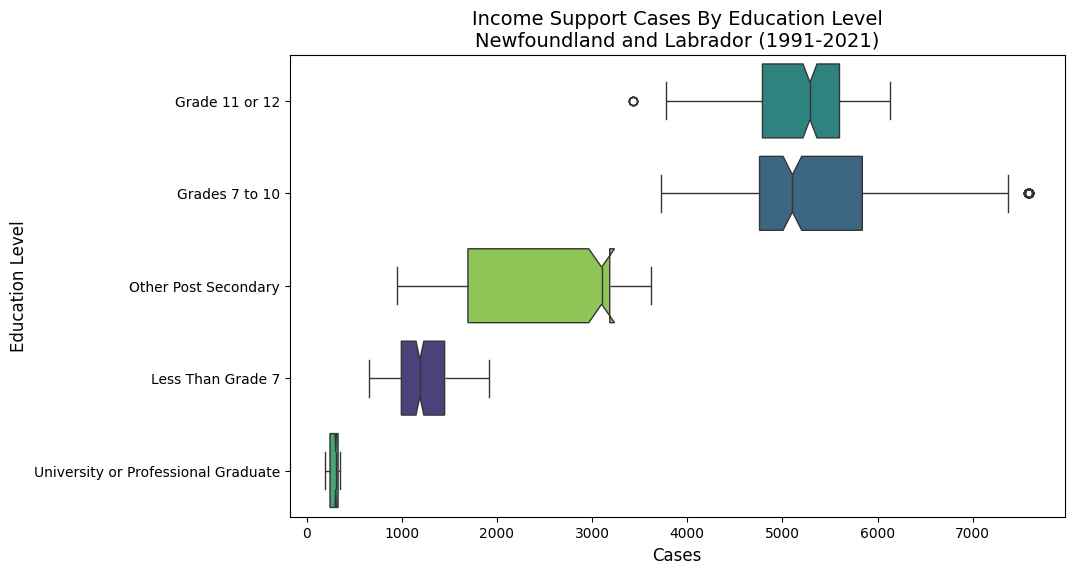

In [351]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = data.copy()

df = df.dropna(subset=[
    'Education..Less.than.grade.7',
    'Education..Grades.7.to.10',
    'Education..Grade.11.or.12',
    'Education..University.or.professional.graduate',
    'Education..Other.post.secondary'
])

melted_df = pd.melt(
    df, 
    id_vars=['Year'], 
    value_vars=[
        'Education..Less.than.grade.7',
        'Education..Grades.7.to.10',
        'Education..Grade.11.or.12',
        'Education..University.or.professional.graduate',
        'Education..Other.post.secondary',
    ], 
    var_name='education_category', 
    value_name='education_category_value'
)

melted_df['education_category_value_sum'] = melted_df.groupby(
    ['Year', 'education_category']
)['education_category_value'].transform('sum')

melted_df['education_category'] = melted_df['education_category'].replace({
    'Education..Less.than.grade.7': 'Less Than Grade 7',
    'Education..Grades.7.to.10': 'Grades 7 to 10',
    'Education..Grade.11.or.12': 'Grade 11 or 12',
    'Education..University.or.professional.graduate': 'University or Professional Graduate',
    'Education..Other.post.secondary': 'Other Post Secondary',
})

medians = melted_df.groupby('education_category')['education_category_value_sum'].median().sort_values(ascending=False)
ordered_categories = medians.index

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="education_category_value_sum", 
    y="education_category", 
    data=melted_df, 
    order=ordered_categories, 
    notch=True, 
    palette="viridis",
    hue="education_category"
)

plt.title('Income Support Cases By Education Level\nNewfoundland and Labrador (1991-2021)', fontsize=14)
plt.xlabel('Cases', fontsize=12)
plt.ylabel('Education Level', fontsize=12)

plt.show()

Grades **7-10** and **grade 11 or 12** has the largest spread, indicating a high amount of variability in the number of income support cases. **Grade 11 or 12** has the highest median number of cases of any group. Both groups demonstrate long whiskers and outliers on the high end (this is particularly so for grades 7 to 10). This could be due to some of the individuals in that group requiring much more support than the majority. The **less than grade 7** group's spread is smaller, indicating fewer income support cases in general. **University or professional graduates** had the smallest spread and the lowest median number of cases of an grooup; in short, individuals with higher education levels, particularly university degrees, are less likely to require income support.

Education level appears to be inversely correlated with income support cases; the higher the education level, the fewer the cases in the respective group. This highlights the importance of one pursuing a post secondary education; it makes one far less likely to require financial support in the future of any kind, including income support.

## How does poor education and unemployment affect the total number of individuals on income support?

First, we should determine whether or not any correlation exists between the variables in question. We can do so by examining a correlation matrix.

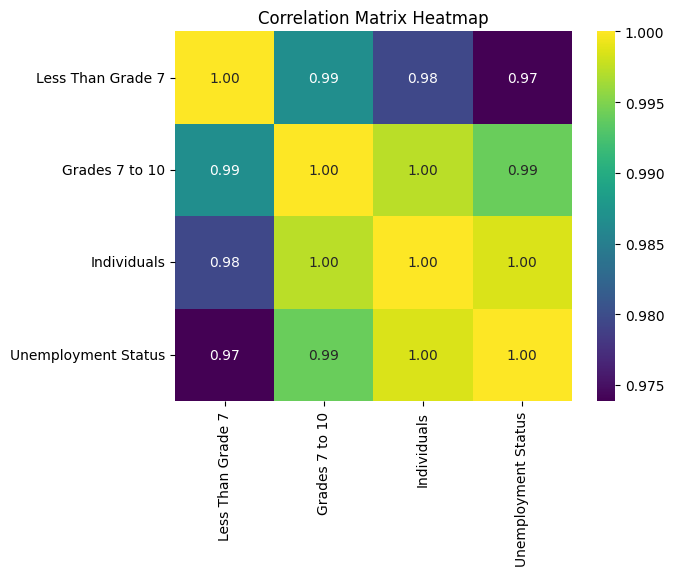

In [352]:
df = data.copy()
df = df.filter(items=['Education..Less.than.grade.7','Education..Grades.7.to.10','Individuals','Employment.Status..Unemployed'])
df.rename(columns={
    'Education..Less.than.grade.7': 'Less Than Grade 7',
    'Education..Grades.7.to.10':'Grades 7 to 10',
    'Employment.Status..Unemployed':'Unemployment Status'
}, inplace=True)

correlation_matrix = df.corr()

# Plot the correlation matrix as a heat map.
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()


The correlation matrix reveals a high, **positive** linear correlation between the different variables under consideration. We can attempt to model this relationship with a **linear regression.**

### Linear Regression

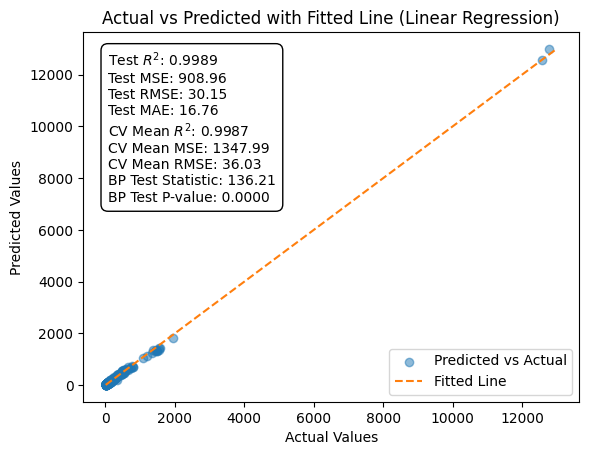

In [353]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Assuming `data` is already loaded
df = data.copy()
df.dropna(subset=['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed'], inplace=True)

# Split data into features (X) and target (y)
X = df[['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed']]  # Features
y = df['Individuals']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Cross-validation
cv_mse_scores = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')  # Convert negative MSE to positive
cv_rmse_scores = np.sqrt(cv_mse_scores)  # Compute RMSE for each fold
cv_r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')  # R^2 scores for each fold

# Cross-validation metrics
cv_mse_mean = np.mean(cv_mse_scores)
cv_rmse_mean = np.mean(cv_rmse_scores)
cv_r2_mean = np.mean(cv_r2_scores)

# Residuals
residuals = y_test - y_pred

# Perform Breusch-Pagan test
X_with_const = sm.add_constant(X_test)  # Add a constant to the independent variables
bp_test = het_breuschpagan(residuals, X_with_const)
bp_test_stat = bp_test[0]  # BP test statistic
bp_p_value = bp_test[1]  # P-value of the test

# Create a formatted string for performance metrics
metrics_text = (
    f"Test $R^2$: {r2:.4f}\n"
    f"Test MSE: {mse:.2f}\n"
    f"Test RMSE: {rmse:.2f}\n"
    f"Test MAE: {mae:.2f}\n"
    f"CV Mean $R^2$: {cv_r2_mean:.4f}\n"
    f"CV Mean MSE: {cv_mse_mean:.2f}\n"
    f"CV Mean RMSE: {cv_rmse_mean:.2f}\n"
    f"BP Test Statistic: {bp_test_stat:.2f}\n"
    f"BP Test P-value: {bp_p_value:.4f}"
)

# Scatter plot of actual vs predicted
plt.scatter(y_test, y_pred, color='tab:blue', label='Predicted vs Actual', alpha=0.5)

# Fitted line
line_start = min(y_test.min(), y_pred.min())
line_end = max(y_test.max(), y_pred.max())
plt.plot([line_start, line_end], [line_start, line_end], color='tab:orange', linestyle='--', label='Fitted Line')

# Add performance metrics as text on the plot
plt.text(
    0.05, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")
)

# Labels and legend
plt.title("Actual vs Predicted with Fitted Line (Linear Regression)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(False)

plt.show()


The predicted values closely align with the actual values along the fitted line, indicating a good fit overall. Indeed, the high $R^2$ and CV mean $R^2$ seem to confirm this. The RMSE value is low when compared to the scale of predicted values and the MAE is also low, further confirming the accuracy of the model. The results of the Breusch-Pagan test are less positive, with a P-value that is effectively zero confirming the presence of heteroscedasticity.

We should explore this further by examining a plot of the residuals.

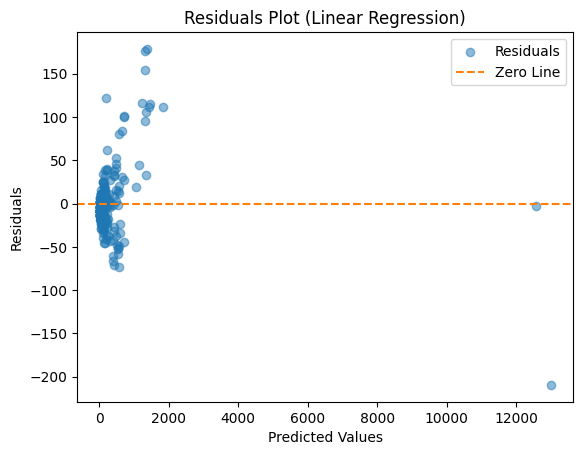

In [354]:
residuals = y_test - y_pred

# Display a scatter plot of the residuals.
plt.scatter(y_pred, residuals, color='tab:blue', alpha=0.5, label='Residuals')
plt.axhline(y=0, color='tab:orange', linestyle='--', label='Zero Line')

plt.title("Residuals Plot (Linear Regression)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(False)

plt.show()

There are patterns in the residuals plot. The residuals appear to be concentrated aroud lower predicted values, with very few points at the higher end. The model may be underestimating or overestimating for larger predicted values. The latter points (around 12,000) **could** be outliers, or data points where the model had trouble making accurate predictions.

There is evidence of **heteroscedasticity.** The spread of the residuals increases as the predicted values grow. This could suggest that the model's assumptions about the data are incorrect. Education levels and unemployment status are **certainly** correlated with a lower incidence of income support cases, but the model of the relationship between these variables may, in this case, need adjustment. One potential adjustment would be to log transform the dependent variable before splitting the training and test data sets.

#### Linear Regression, Log Transformation

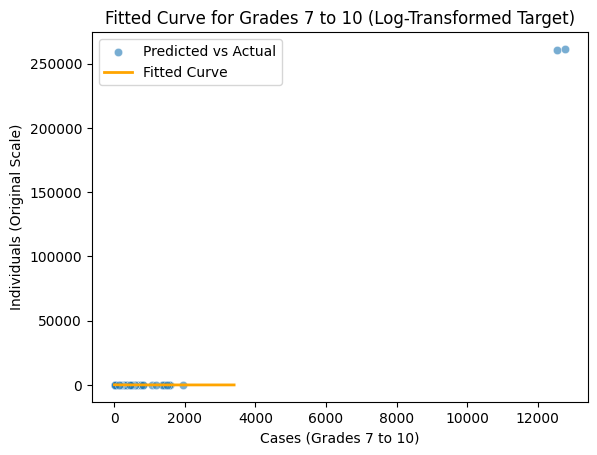

In [355]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
df = data.copy()
df.dropna(subset=['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed'], inplace=True)

# Split data into features (X) and target (Y)
X = df[['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed']]  # Features
y = np.log(df['Individuals'])  # Log-transform the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_log = model.predict(X_test)  # Predictions in log scale
y_pred = np.exp(y_pred_log)  # Convert predictions back to original scale



# Evaluate the model
mse = mean_squared_error(np.exp(y_test), y_pred)  # Compare in the original scale
r2 = r2_score(np.exp(y_test), y_pred)

# Optionally: Evaluate in the log scale
mse_log = mean_squared_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)

# Select a feature for the fitted curve
feature_name = 'Education..Grades.7.to.10'
feature_index = X.columns.get_loc(feature_name)
feature_range = np.linspace(X[feature_name].min(), X[feature_name].max(), 100)

# Generate predictions for the fitted curve
X_curve = X_test.mean().to_frame().T  # Use mean values for other features
X_curve = X_curve.loc[np.zeros(len(feature_range), dtype=int)]  # Replicate for each value in the range
X_curve[feature_name] = feature_range
y_curve_log = model.predict(X_curve)  # Predict in log scale
y_curve = np.exp(y_curve_log)  # Convert back to original scale

# Scatter plot: Actual vs. predicted
sns.scatterplot(x=np.exp(y_test), y=y_pred, label='Predicted vs Actual', alpha=0.6)

# Add the fitted curve
plt.plot(feature_range, y_curve, color='orange', label='Fitted Curve', linewidth=2)

# Plot customization
plt.title(f"Fitted Curve for Grades 7 to 10 (Log-Transformed Target)")
plt.xlabel("Cases (Grades 7 to 10)")
plt.ylabel("Individuals (Original Scale)")
plt.legend()
plt.grid(False)
plt.show()


It does not appear that a log transformation of the dependent variable improves the efficacy of the model in this case. We can examine the residuals plot to be certain.

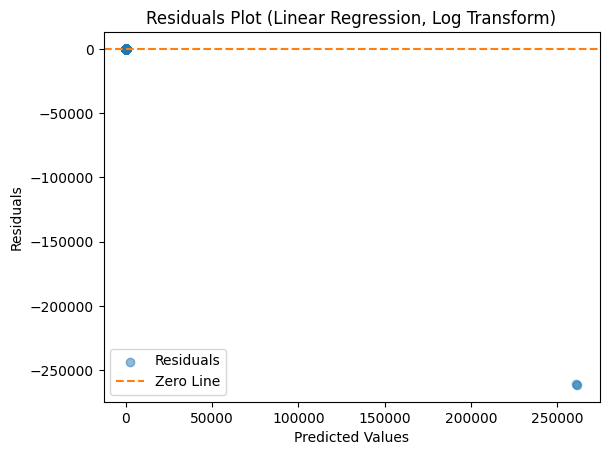

In [356]:
residuals = y_test - y_pred

# Display a scatter plot of the residuals.
plt.scatter(y_pred, residuals, color='tab:blue', alpha=0.5, label='Residuals')
plt.axhline(y=0, color='tab:orange', linestyle='--', label='Zero Line')

plt.title("Residuals Plot (Linear Regression, Log Transform)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(False)

plt.show()

There is a very obvious and large range to the residuals in this example. A few residual points deviate significantly from the zero line, indicating poor model performance or potential outliers. In addition, the spread of the residuals is not even. For smaller predicted values, the residuals are tightly clustered near the zero line, while for larger predicted values, they increase significantly. This could indicate **heteroscedasticity.** In either case, a simple log transformation is not sufficient to resolve the issues with this particular model.

We could, instead of a simple linear regression, attempt to apply a polynomial regression to the same data set.

### Polynomial Regression

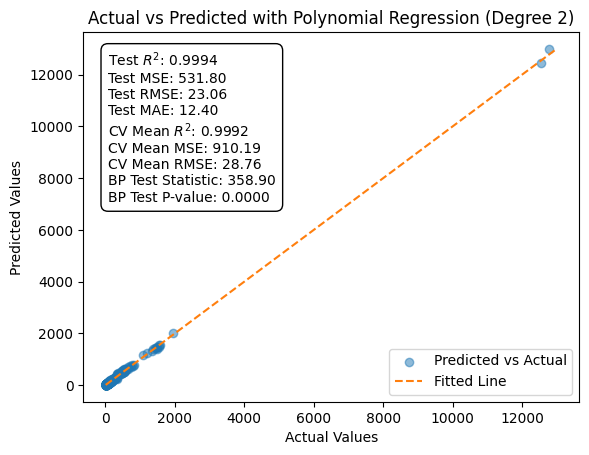

In [357]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Assuming `data` is already loaded
df = data.copy()
df.dropna(subset=['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed'], inplace=True)

# Split data into features (X) and target (y)
X = df[['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed']]  # Features
y = df['Individuals']  # Target

# Polynomial transformation
degree = 2  # You can adjust the degree of the polynomial
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train a polynomial regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Cross-validation
cv_mse_scores = -cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error')  # Convert negative MSE to positive
cv_rmse_scores = np.sqrt(cv_mse_scores)  # Compute RMSE for each fold
cv_r2_scores = cross_val_score(model, X_poly, y, cv=5, scoring='r2')  # R^2 scores for each fold

# Cross-validation metrics
cv_mse_mean = np.mean(cv_mse_scores)
cv_rmse_mean = np.mean(cv_rmse_scores)
cv_r2_mean = np.mean(cv_r2_scores)

# Residuals
residuals = y_test - y_pred

# Perform Breusch-Pagan test
X_with_const = sm.add_constant(X_test)  # Add a constant to the independent variables
bp_test = het_breuschpagan(residuals, X_with_const)
bp_test_stat = bp_test[0]  # BP test statistic
bp_p_value = bp_test[1]  # P-value of the test

# Create a formatted string for performance metrics
metrics_text = (
    f"Test $R^2$: {r2:.4f}\n"
    f"Test MSE: {mse:.2f}\n"
    f"Test RMSE: {rmse:.2f}\n"
    f"Test MAE: {mae:.2f}\n"
    f"CV Mean $R^2$: {cv_r2_mean:.4f}\n"
    f"CV Mean MSE: {cv_mse_mean:.2f}\n"
    f"CV Mean RMSE: {cv_rmse_mean:.2f}\n"
    f"BP Test Statistic: {bp_test_stat:.2f}\n"
    f"BP Test P-value: {bp_p_value:.4f}"
)

# Scatter plot of actual vs predicted
plt.scatter(y_test, y_pred, color='tab:blue', label='Predicted vs Actual', alpha=0.5)

# Fitted line (diagonal line for comparison)
line_start = min(y_test.min(), y_pred.min())
line_end = max(y_test.max(), y_pred.max())
plt.plot([line_start, line_end], [line_start, line_end], color='tab:orange', linestyle='--', label='Fitted Line')

# Add performance metrics as text on the plot
plt.text(
    0.05, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")
)

# Labels and legend
plt.title(f"Actual vs Predicted with Polynomial Regression (Degree {degree})")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(False)

plt.show()


The test $R^2$ indicates that the model explains nearly all of the variance seen in the data, indicating a very good fit. In addition, the $RMSE$ and $MAE$ values are both low compared to the scale of predicted vaues. This demonstrates a minimal amount of error in predictions. The cross-validation metrics also show very low errors. The results of the Breusch-Pagan test indicate heteroscedasticity, however. We should examine this further with a plot of the residuals.

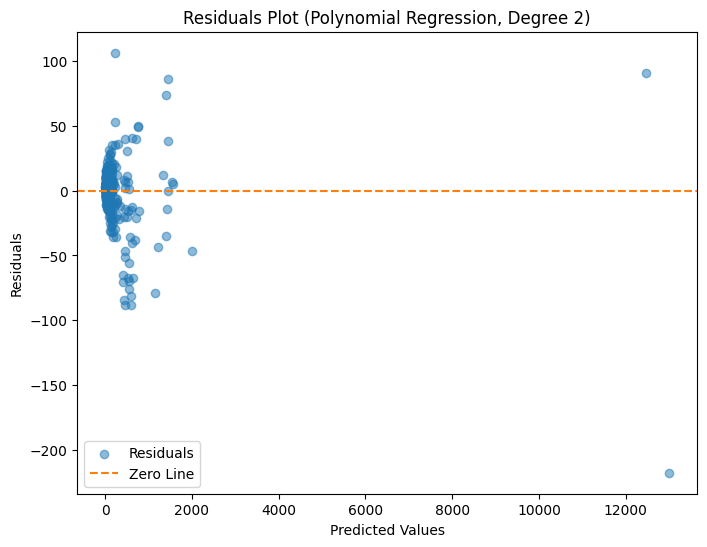

In [358]:
# Residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='tab:blue', alpha=0.5,label="Residuals")
plt.axhline(0, color='tab:orange', linestyle='--', linewidth=1.5, label='Zero Line')

# Labels and title
plt.title(f"Residuals Plot (Polynomial Regression, Degree {degree})")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(False)

plt.show()

The residuals demonstrate increasing variance for larger predicted values, indicating heteroscedasticity, matching up with the performance metrics seen earlier. This "violates one of the key assumptions in linear regression,"<sup>1</sup> that the variance of residuals remains constant. There are visible outliers which may severely impact the performance of the model and should be addressed. Most of the residuals are clustered around the 0-2000 marks, indicating that the model may be overfitting or underfitting specific regions of the data.

We could try the same approach, but with any potential outliers removed before analysis.

#### Polynomial Regression, Outliers Removed

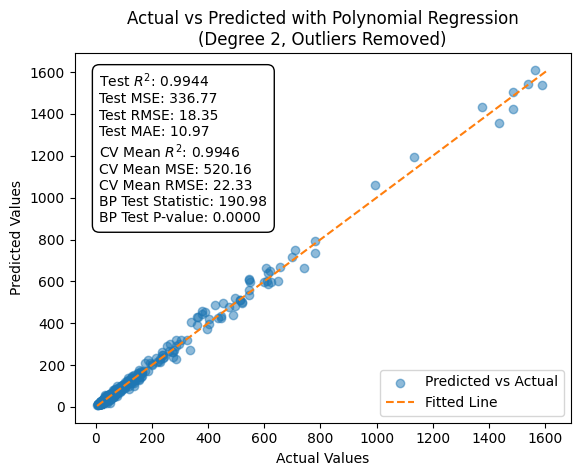

In [359]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from scipy.stats import zscore

# Assuming `data` is already loaded
df = data.copy()
df.dropna(subset=['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed'], inplace=True)

# Remove outliers using Z-scores
z_scores = np.abs(zscore(df[['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed', 'Individuals']]))
threshold = 3  # Common threshold for outlier detection
df = df[(z_scores < threshold).all(axis=1)]  # Keep only rows where all Z-scores are below the threshold

# Split data into features (X) and target (y)
X = df[['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed']]  # Features
y = df['Individuals']  # Target

# Polynomial transformation
degree = 2  # You can adjust the degree of the polynomial
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train a polynomial regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Cross-validation
cv_mse_scores = -cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error')  # Convert negative MSE to positive
cv_rmse_scores = np.sqrt(cv_mse_scores)  # Compute RMSE for each fold
cv_r2_scores = cross_val_score(model, X_poly, y, cv=5, scoring='r2')  # R^2 scores for each fold

# Cross-validation metrics
cv_mse_mean = np.mean(cv_mse_scores)
cv_rmse_mean = np.mean(cv_rmse_scores)
cv_r2_mean = np.mean(cv_r2_scores)

# Residuals
residuals = y_test - y_pred

# Perform Breusch-Pagan test
X_with_const = sm.add_constant(X_test)  # Add a constant to the independent variables
bp_test = het_breuschpagan(residuals, X_with_const)
bp_test_stat = bp_test[0]  # BP test statistic
bp_p_value = bp_test[1]  # P-value of the test

# Create a formatted string for performance metrics
metrics_text = (
    f"Test $R^2$: {r2:.4f}\n"
    f"Test MSE: {mse:.2f}\n"
    f"Test RMSE: {rmse:.2f}\n"
    f"Test MAE: {mae:.2f}\n"
    f"CV Mean $R^2$: {cv_r2_mean:.4f}\n"
    f"CV Mean MSE: {cv_mse_mean:.2f}\n"
    f"CV Mean RMSE: {cv_rmse_mean:.2f}\n"
    f"BP Test Statistic: {bp_test_stat:.2f}\n"
    f"BP Test P-value: {bp_p_value:.4f}"
)

# Scatter plot of actual vs predicted
plt.scatter(y_test, y_pred, color='tab:blue', label='Predicted vs Actual', alpha=0.5)

# Fitted line (diagonal line for comparison)
line_start = min(y_test.min(), y_pred.min())
line_end = max(y_test.max(), y_pred.max())
plt.plot([line_start, line_end], [line_start, line_end], color='tab:orange', linestyle='--', label='Fitted Line')

# Add performance metrics as text on the plot
plt.text(
    0.05, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")
)

# Labels and legend
plt.title(f"Actual vs Predicted with Polynomial Regression\n(Degree {degree}, Outliers Removed)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(False)

plt.show()


The predictions in this case align very closely with their actual values, as evidenced by how tightly they are clustered around the fitted line. The $R^2$ value indicates a strong fit, with a low $RMSE$ value suggesting that the residual errors are small. The $MAE$ is also very low, indicating that the model's predictions are very close to the actual values, on average. The cross-validation metrics support the strength of the model. A high CV Mean $R^2$ that is almost identitical to the $R^2$ value indicates that the model "generalizes well across different subsets of data."<sup>1</sup> The extremely low BP $p$-value suggests heteroscedasticity, however, so a residuals plot should be generated and analyzed.

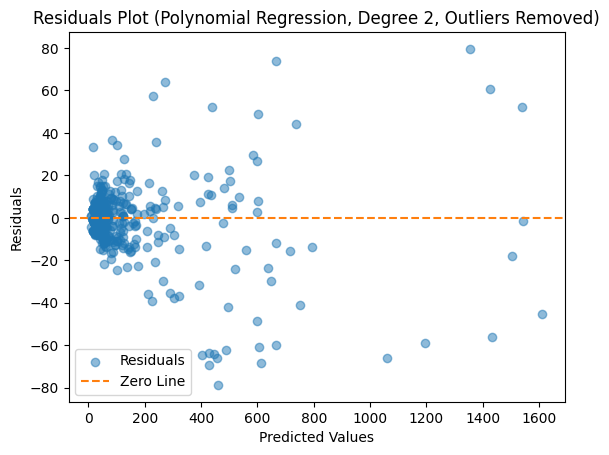

In [360]:
# Residual plot
plt.scatter(y_pred, residuals, color='tab:blue', alpha=0.5, label='Residuals')
plt.axhline(0, color='tab:orange', linestyle='--', label='Zero Line')

# Labels and legend
plt.title(f"Residuals Plot (Polynomial Regression, Degree {degree}, Outliers Removed)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(False)

plt.show()


The residuals are closely centered about the zero line; for the majority of observations, the model is fitting well. The spread of the residuals increases with larger predicted values, however, suggesting heteroscedasticity. Apart from this increasing spread, however, there are no obvious patterns or trends. This is perhaps the best modelling result seen so far; with the outliers removed, polynomial regression performs exceptionally well against the data.

### Ridge Regression

With **polynomial regression,** the relationship between the independent variable and the dependent variable is modeled as an $n$-degree polynomial. It is an extension of linear regression that attempts to fit a non-linear curve to the data. In contrast, **ridge regression** is a type of linear regression with [regularization,](https://en.wikipedia.org/wiki/Regularization_(mathematics)) a process that "converts the answer of a problem to a simpler one," according to Wikipedia. Whereas polynomial regression handles non-linear relationships on its own, ridge regression requires adjustment and carefully engineered features in order to deal with non-linearity in the data. Polynomial regression is prone to overfitting; in contrast, ridge regression provides penalties for large coefficients that prevent such overfitting. The general purpose behind both approaches differs as well; polynomial regression, as stated previously, is used to model non-linear relationships in the data. The key point to ridge regression is regularization; ridge regression is used to regularize linear models that may suffer from overfitting.

How does all of this apply to our data set? We can evaluate the performance of the model in a similar fashion to the others we have studied.

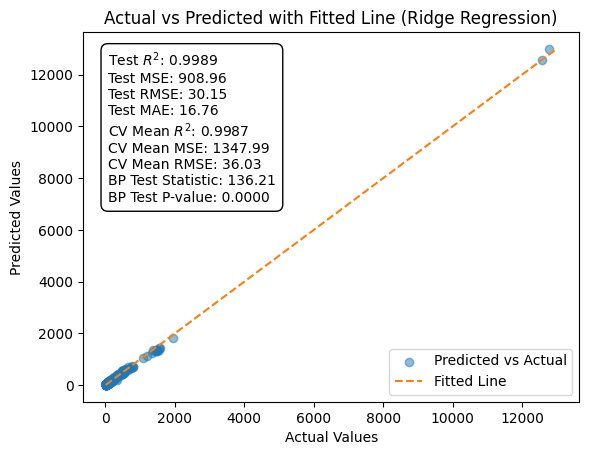

In [361]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Assuming `data` is already loaded
df = data.copy()
df.dropna(subset=['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed'], inplace=True)

# Split data into features (X) and target (y)
X = df[['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed']]  # Features
y = df['Individuals']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # You can tune alpha as needed
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Cross-validation
cv_mse_scores = -cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')  # Convert negative MSE to positive
cv_rmse_scores = np.sqrt(cv_mse_scores)  # Compute RMSE for each fold
cv_r2_scores = cross_val_score(ridge_model, X, y, cv=5, scoring='r2')  # R^2 scores for each fold

# Cross-validation metrics
cv_mse_mean = np.mean(cv_mse_scores)
cv_rmse_mean = np.mean(cv_rmse_scores)
cv_r2_mean = np.mean(cv_r2_scores)

# Residuals
residuals = y_test - y_pred

# Perform Breusch-Pagan test
X_with_const = sm.add_constant(X_test)  # Add a constant to the independent variables
bp_test = het_breuschpagan(residuals, X_with_const)
bp_test_stat = bp_test[0]  # BP test statistic
bp_p_value = bp_test[1]  # P-value of the test

# Create a formatted string for performance metrics
metrics_text = (
    f"Test $R^2$: {r2:.4f}\n"
    f"Test MSE: {mse:.2f}\n"
    f"Test RMSE: {rmse:.2f}\n"
    f"Test MAE: {mae:.2f}\n"
    f"CV Mean $R^2$: {cv_r2_mean:.4f}\n"
    f"CV Mean MSE: {cv_mse_mean:.2f}\n"
    f"CV Mean RMSE: {cv_rmse_mean:.2f}\n"
    f"BP Test Statistic: {bp_test_stat:.2f}\n"
    f"BP Test P-value: {bp_p_value:.4f}"
)

# Scatter plot of actual vs predicted
plt.scatter(y_test, y_pred, color='tab:blue', label='Predicted vs Actual', alpha=0.5)

# Fitted line
line_start = min(y_test.min(), y_pred.min())
line_end = max(y_test.max(), y_pred.max())
plt.plot([line_start, line_end], [line_start, line_end], color='tab:orange', linestyle='--', label='Fitted Line')

# Add performance metrics as text on the plot
plt.text(
    0.05, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")
)

# Labels and legend
plt.title("Actual vs Predicted with Fitted Line (Ridge Regression)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(False)

plt.show()


The test $R^2$ in this case is exceptionally high, explaining nearly all the variance seen in the data. The $RMSE$ value is low in comparison to the scale of predicted values, as is the $MAE.$ This indicates that the average error in predictions is low and that the model's predictions are, on average, off by a very small amount. The cross-validation metrics all verify the model's performance across different folds. The Breusch-Pagan test still reveals heteroscedasticity in the residuals, however, so a residuals plot shoud be examined. 

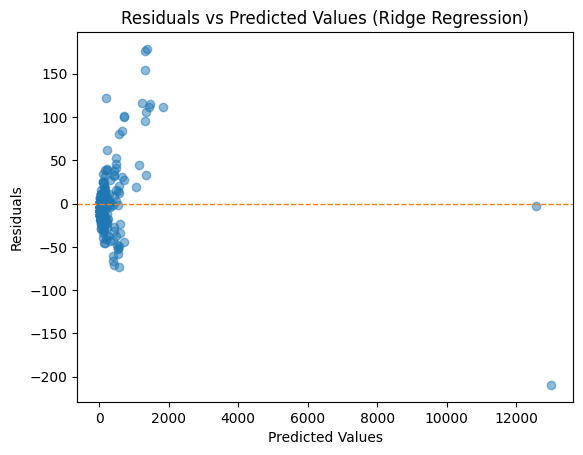

In [362]:
# Residuals plot
plt.scatter(y_pred, residuals, color='tab:blue', alpha=0.5)
plt.axhline(0, color='tab:orange', linestyle='--', linewidth=1)  # Horizontal line at 0
plt.title("Residuals vs Predicted Values (Ridge Regression)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(False)
plt.show()

For smaller predicted values the residuals are clustered near zero, though there is evidence of a "fanning out" as predicted values increase, confirming the results of the Breusch-Pagan test for heteroscedasticity. The spread of the residuals is uneven, with a tight concentration for lower predicted values, but a much wider spread for larger predicted values. There are also outliers present at the extreme end of predicted values, which could impact the performance of the model.

What if the outliers are removed before analysis?

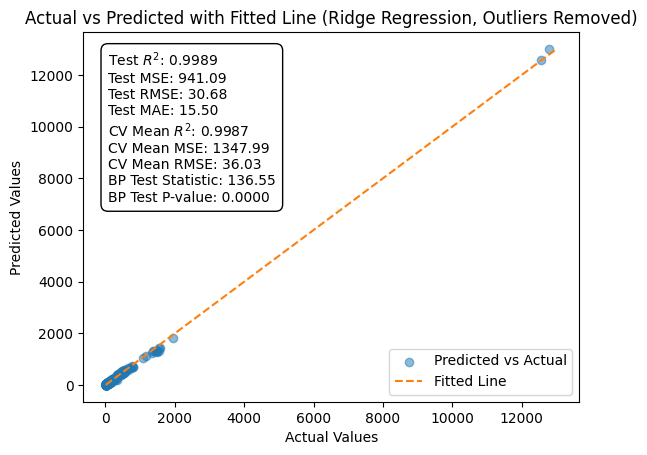

In [363]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Assuming `data` is already loaded
df = data.copy()
df.dropna(subset=['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed'], inplace=True)

# Split data into features (X) and target (y)
X = df[['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed']]  # Features
y = df['Individuals']  # Target

# Initial Ridge Regression to detect outliers
X_train_initial, X_test_initial, y_train_initial, y_test_initial = train_test_split(X, y, test_size=0.2, random_state=42)
ridge_model_initial = Ridge(alpha=1.0)
ridge_model_initial.fit(X_train_initial, y_train_initial)
y_pred_initial = ridge_model_initial.predict(X_train_initial)
residuals_initial = y_train_initial - y_pred_initial

# Identify outliers (e.g., residuals > 3 standard deviations from the mean)
threshold = 3 * np.std(residuals_initial)
non_outliers_mask = np.abs(residuals_initial) <= threshold

# Remove outliers from training data
X_train_filtered = X_train_initial[non_outliers_mask]
y_train_filtered = y_train_initial[non_outliers_mask]

# Train Ridge Regression on filtered data
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_filtered, y_train_filtered)

# Evaluate the model on the test data
y_pred = ridge_model.predict(X_test_initial)
mse = mean_squared_error(y_test_initial, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test_initial, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test_initial, y_pred)  # R-squared

# Cross-validation
cv_mse_scores = -cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')  # Convert negative MSE to positive
cv_rmse_scores = np.sqrt(cv_mse_scores)  # Compute RMSE for each fold
cv_r2_scores = cross_val_score(ridge_model, X, y, cv=5, scoring='r2')  # R^2 scores for each fold

# Cross-validation metrics
cv_mse_mean = np.mean(cv_mse_scores)
cv_rmse_mean = np.mean(cv_rmse_scores)
cv_r2_mean = np.mean(cv_r2_scores)

# Residuals
residuals = y_test_initial - y_pred

# Perform Breusch-Pagan test
X_with_const = sm.add_constant(X_test_initial)  # Add a constant to the independent variables
bp_test = het_breuschpagan(residuals, X_with_const)
bp_test_stat = bp_test[0]  # BP test statistic
bp_p_value = bp_test[1]  # P-value of the test

# Create a formatted string for performance metrics
metrics_text = (
    f"Test $R^2$: {r2:.4f}\n"
    f"Test MSE: {mse:.2f}\n"
    f"Test RMSE: {rmse:.2f}\n"
    f"Test MAE: {mae:.2f}\n"
    f"CV Mean $R^2$: {cv_r2_mean:.4f}\n"
    f"CV Mean MSE: {cv_mse_mean:.2f}\n"
    f"CV Mean RMSE: {cv_rmse_mean:.2f}\n"
    f"BP Test Statistic: {bp_test_stat:.2f}\n"
    f"BP Test P-value: {bp_p_value:.4f}"
)

# Scatter plot of actual vs predicted
plt.scatter(y_test_initial, y_pred, color='tab:blue', label='Predicted vs Actual', alpha=0.5)

# Fitted line
line_start = min(y_test_initial.min(), y_pred.min())
line_end = max(y_test_initial.max(), y_pred.max())
plt.plot([line_start, line_end], [line_start, line_end], color='tab:orange', linestyle='--', label='Fitted Line')

# Add performance metrics as text on the plot
plt.text(
    0.05, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")
)

# Labels and legend
plt.title("Actual vs Predicted with Fitted Line (Ridge Regression, Outliers Removed)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(False)

plt.show()


The performance metrics with the outliers removed look very promising, as they did before. What about the residuals plot?

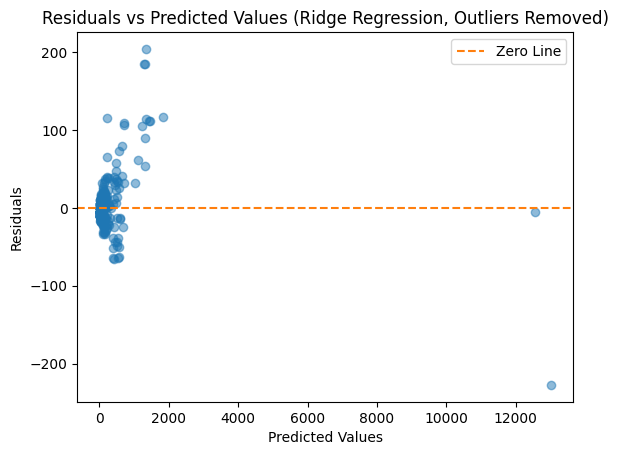

In [364]:
# Residuals plot
plt.scatter(y_pred, residuals, color='tab:blue', alpha=0.5)
plt.axhline(y=0, color='tab:orange', linestyle='--', label='Zero Line')
plt.title("Residuals vs Predicted Values (Ridge Regression, Outliers Removed)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(False)
plt.show()

The residuals are initially tightly clustered around zero, but the spread increases as the predicted values increase, suggesting heteroscedasticity; they could also suggest "model misspecification or omitted variables that affect predictions for higher values."<sup>1</sup> There are significant outliers in the plot as well, particularly for higher predicted values. In short, the performance of the model at low predicted values is much better than at high predicted values.

### Choice of Model?

The polynomial regression model (of degree 2 and with outliers removed) and the ridge regression model (with outliers removed) both seemed to perform relatively well against the data. The question arises then, which is more appropriate for modelling the relationship between poor education, unemployment and total income support cases?

In the case of polynomial regression, the residuals were scattered more uniformly across the range of predicted values. There does appear to be some heteroscedasticity, as the spread of the residuals increases with an increase in predicted values. The residuals cluster more closely about the zero line for lower predicted values, but at higher values they show more variance.

With ridge regression, the residuals are more tightly clustered about the zero line for smaller predicted values. There are a few extreme residuals at very high predicted values, however, suggesting that the model struggles with these. values. Finally, the spread of the residuals in the ridge regression plot seem far less consistent compared to that of the polynomial regression plot.

Ultimately, the choice of model in this case comes down to one's goals:

- "If your goal is general prediction accuracy across all ranges of predicted values, the [polynomial regression] model might be better because it appears to distribute errors more evenly."<sup>1</sup>
- "If your goal is to minimize extreme residuals or you're focusing on smaller predicted values, then [ridge regression] could be more suitable, but you would need to investigate and handle the outliers causing the large errors at higher predicted values."<sup>1</sup>

# Families

## How large were the families of income support cases on average?

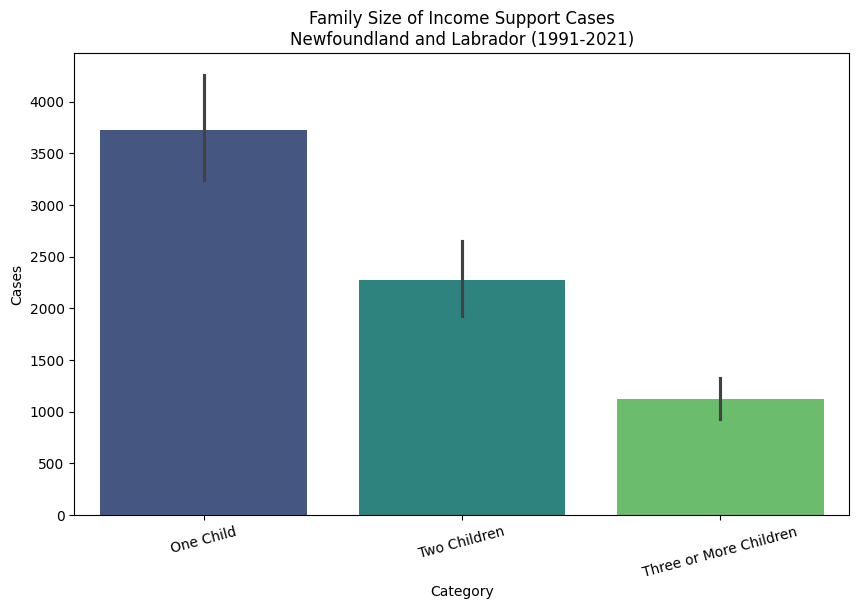

In [365]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = data.copy()
df.dropna(subset=['Children..One.child', 'Children..Two.children', 'Children..Three.or.more.children'], inplace=True)

melted_df = df.melt(
    id_vars=['Year'],
    value_vars=['Children..One.child', 'Children..Two.children', 'Children..Three.or.more.children'],
    var_name='children_category',
    value_name='children_category_values'
)

melted_df['children_category'] = melted_df['children_category'].replace({
   'Children..One.child': 'One Child', 
   'Children..Two.children': 'Two Children',
   'Children..Three.or.more.children': 'Three or More Children',
})

# Calculate the total sum for each category across all years.
category_order = (
    melted_df.groupby('children_category')['children_category_values']
    .sum()
    .sort_values(ascending=False)
    .index
)

# Reorder the categories based on the sorted sums.
summed_df = melted_df.groupby(['children_category', 'Year'])['children_category_values'].sum().reset_index()
summed_df['children_category'] = pd.Categorical(
    summed_df['children_category'],
    categories=category_order,
    ordered=True
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=summed_df,
    x='children_category',
    y='children_category_values',
    palette='viridis',
    hue="children_category",
    order=category_order  # This line ensures the bars are sorted from greatest to least.
)
plt.title('Family Size of Income Support Cases\nNewfoundland and Labrador (1991-2021)')
plt.xlabel('Category')
plt.ylabel('Cases')
plt.xticks(rotation=15)
plt.show()


The majority of families on income support have only **one** child.

## How much in benefits were paid out to families on average?

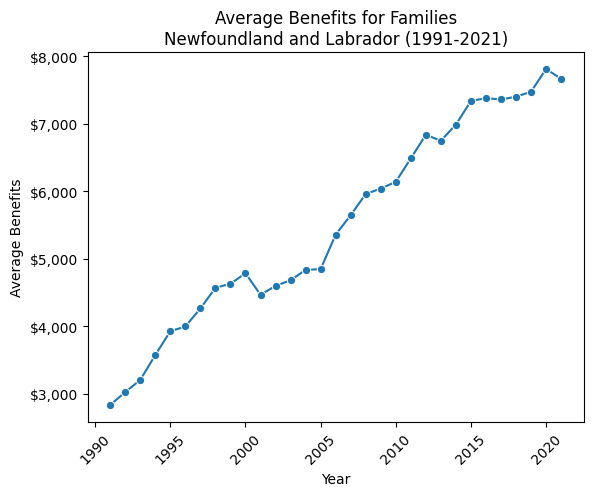

In [366]:
df = data.copy()
df.dropna(subset=["Total.Families..Average.benefits"], inplace=True)

df = df.groupby('Year')['Total.Families..Average.benefits'].mean().sort_values(ascending=False).reset_index()

sns.lineplot(
    data=df,
    x='Year',
    y='Total.Families..Average.benefits',
    marker='o',
    color='tab:blue'
)

# Format y-axis as currency.
def currency_formatter(x, pos):
    return f'${x:,.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

plt.title('Average Benefits for Families\nNewfoundland and Labrador (1991-2021)')
plt.xlabel('Year')
plt.ylabel('Average Benefits')
plt.grid(False)
plt.xticks(rotation=45)

plt.show()


The amount paid out to families in income support benefits has **increased** with time, to keep pace with economic factors such as inflation and rising costs of living. A family on income support in 1991 received an average of less than $2,000 in benefits per year. A family in 2021 received more than **double** that amount. The steady growth in the amount of average benefits paid out indicates a positive trend in the financial support provided for families.

From around 2005 onward, there is a more steady progression in the increase in average benefits. In later years this growth slows down slightly, so that by 2020 they have either reached a peak, or the rate of increase stabilized. The overall trend represents long-term commitment by government and policy makers to improve the condition of families on income support across the province.

# Conclusion

A number of interesting facts have been revealed by this study. In terms of age groups, the age range of **25-54** had the most number of income support cases in the province. However, the authors of the data set note in the accompanying metadata that this age range is considered the "prime" labour force age range. Nonetheless, the majority of income support cases fall within this range. 

Income support recipients were more likely to be poorly educated and unemployed. This relationship was studied through the use of a number of regression models. Of these, the polynomial regression method (of degree 2 and with outliers removed) seemed to produce the most desirable the results. There is a definite, **positive** relationship between poor education, unemployment and the number of total income support cases. The best choice of model for analyzing this relationship, however, depends ultimately on one's goals.

Families on income support tended to have one child on average. The amount in benefits paid out to families in the province has increased dramatically over the years, to the point that a family in 2021 received more than **double** the average benefits of a family in 1991. That amount has reached something of a plateau in 2020, which may be of concern. The rising costs of living are a huge issue in Newfoundland and Labrador, so much so that the government has dedicated a huge amount of effort into [addressing the issue.](https://www.gov.nl.ca/fin/cost-of-living-measures/) Even so, the data indicates that there has been a multi-year, sustained effort into providing support for families in the province, as well as to ensure that support matches well with increases in the costs of living.

# Acknowledgements

This notebook was authored with assistance from [ChatGPT](https://chatgpt.com). Math and statistics are not my strong point, so I rely a great deal on research papers, videos and websites which explain the details in terms that anyone can understand. ChatGPT was able not only to answer all my questions regarding the heavy math and theory involved in such a project, it also generated a lot of the more complex and mathematical code that was simply beyond me. ChatGPT allowed me to complete the notebook with a much greater understanding of the subject material in the end. My thanks to **OpenAI** for providing such an amazing tool to the public, free of charge.

# References

<sup>1</sup> OpenAI. (2024). ChatGPT (January 11 version) [Large language model]. https://chat.openai.com